<a href="https://colab.research.google.com/github/nikogarro/thesis/blob/main/Pill_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/OlgaChernytska/Visual-Inspection.git

Cloning into 'Visual-Inspection'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 110 (delta 2), reused 5 (delta 1), pack-reused 104
Receiving objects: 100% (110/110), 329.09 MiB | 25.50 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (24/24), done.


In [6]:
ls

pill/  pill.tar.xz  sample_data/  Visual-Inspection/


Data by MVTec Anomaly Detection Dataset (MVTec AD)

Paul Bergmann, Michael Fauser, David Sattlegger, and Carsten Steger,
"A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection",
IEEE Conference on Computer Vision and Pattern Recognition, 2019

In [3]:
!wget https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz

--2023-08-21 10:22:06--  https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 275267152 (263M) [application/x-xz]
Saving to: ‘pill.tar.xz’

pill.tar.xz         100%[===================>] 262.51M  19.9MB/s    in 14s     

2023-08-21 10:22:21 (18.7 MB/s) - ‘pill.tar.xz’ saved [275267152/275267152]



In [5]:
!tar -xf pill.tar.xz

In [7]:
import sys
sys.path.append('/content/Visual-Inspection/utils/')

In [8]:
%load_ext autoreload
%autoreload 2

Change dataloader.py helper.py and model.py from utils.constants to constants

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from dataloader import get_train_test_loaders, get_cv_train_test_loaders
from model import CustomVGG
from helper import train, evaluate, predict_localize
from constants import NEG_CLASS

# Parameters

In [30]:
data_folder = "/content"
subset_name = "pill"
data_folder = os.path.join(data_folder, subset_name)

batch_size = 10
target_train_accuracy = 0.98
lr = 0.0001
epochs = 10
class_weight = [1, 3] if NEG_CLASS == 1 else [3, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

heatmap_thres = 0.7
n_cv_folds = 5

# Data

In [31]:
train_loader, test_loader = get_train_test_loaders(
    root=data_folder, batch_size=batch_size, test_size=0.2, random_state=42,
)

Dataset /content/pill: N Images = 434, Share of anomalies = 0.325


# Model Training


In [32]:
model = CustomVGG()

class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
model = train(
    train_loader, model, optimizer, criterion, epochs, device, target_train_accuracy
)

Epoch 1/10: Loss = 0.6409, Accuracy = 0.4294
Epoch 2/10: Loss = 0.5151, Accuracy = 0.7471
Epoch 3/10: Loss = 0.4296, Accuracy = 0.7882
Epoch 4/10: Loss = 0.3747, Accuracy = 0.8676
Epoch 5/10: Loss = 0.3350, Accuracy = 0.8059
Epoch 6/10: Loss = 0.2490, Accuracy = 0.9176
Epoch 7/10: Loss = 0.1434, Accuracy = 0.9529
Epoch 8/10: Loss = 0.0867, Accuracy = 0.9765
Epoch 9/10: Loss = 0.0745, Accuracy = 0.9824
Early Stopping


In [40]:
model_path = f"/content/{subset_name}_model.h5"
torch.save(model, model_path)
# model = torch.load(model_path, map_location=device)

In [39]:
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Evaluation

Accuracy: 0.8506
Balanced Accuracy: 0.8242



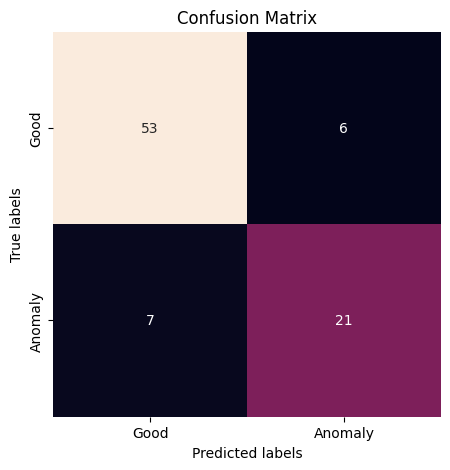

In [15]:
evaluate(model, test_loader, device)


# Cross Validation


Dataset /content/pill: N Images = 434, Share of anomalies = 0.325
Fold 1/5


<ipython-input-17-1e06c56d39b3>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(device)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10: Loss = 0.6946, Accuracy = 0.4618
Epoch 2/10: Loss = 0.6207, Accuracy = 0.4618
Epoch 3/10: Loss = 0.5056, Accuracy = 0.7588
Epoch 4/10: Loss = 0.3977, Accuracy = 0.8059
Epoch 5/10: Loss = 0.3415, Accuracy = 0.8647
Epoch 6/10: Loss = 0.3194, Accuracy = 0.8618
Epoch 7/10: Loss = 0.1852, Accuracy = 0.9235
Epoch 8/10: Loss = 0.2197, Accuracy = 0.9176
Epoch 9/10: Loss = 0.1146, Accuracy = 0.9794
Epoch 10/10: Loss = 0.0907, Accuracy = 0.9706
Accuracy: 0.8621
Balanced Accuracy: 0.8608



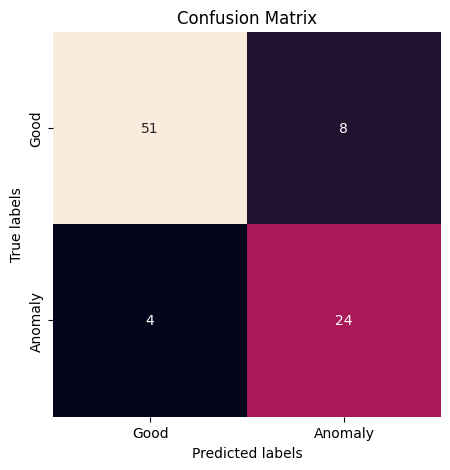

Fold 2/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10: Loss = 0.6773, Accuracy = 0.4353
Epoch 2/10: Loss = 0.5712, Accuracy = 0.5912
Epoch 3/10: Loss = 0.4654, Accuracy = 0.7971
Epoch 4/10: Loss = 0.3191, Accuracy = 0.8824
Epoch 5/10: Loss = 0.2575, Accuracy = 0.9176
Epoch 6/10: Loss = 0.2084, Accuracy = 0.9176
Epoch 7/10: Loss = 0.1930, Accuracy = 0.9294
Epoch 8/10: Loss = 0.1658, Accuracy = 0.9676
Epoch 9/10: Loss = 0.1236, Accuracy = 0.9559
Epoch 10/10: Loss = 0.0718, Accuracy = 0.9853
Accuracy: 0.8851
Balanced Accuracy: 0.8496



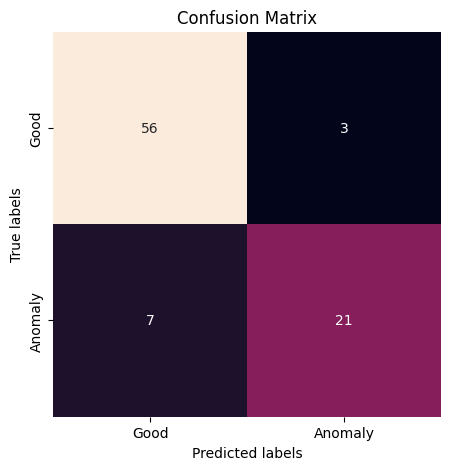

Fold 3/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10: Loss = 0.6883, Accuracy = 0.4147
Epoch 2/10: Loss = 0.5829, Accuracy = 0.5471
Epoch 3/10: Loss = 0.4488, Accuracy = 0.7941
Epoch 4/10: Loss = 0.3147, Accuracy = 0.8765
Epoch 5/10: Loss = 0.2777, Accuracy = 0.8971
Epoch 6/10: Loss = 0.2227, Accuracy = 0.9206
Epoch 7/10: Loss = 0.1345, Accuracy = 0.9735
Epoch 8/10: Loss = 0.0787, Accuracy = 0.9882
Epoch 9/10: Loss = 0.1056, Accuracy = 0.9618
Epoch 10/10: Loss = 0.2592, Accuracy = 0.9118
Accuracy: 0.8506
Balanced Accuracy: 0.8242



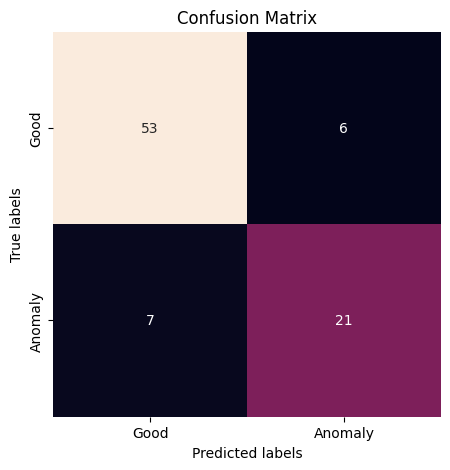

Fold 4/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10: Loss = 0.6880, Accuracy = 0.4794
Epoch 2/10: Loss = 0.6685, Accuracy = 0.3353
Epoch 3/10: Loss = 0.6059, Accuracy = 0.5971
Epoch 4/10: Loss = 0.4711, Accuracy = 0.7735
Epoch 5/10: Loss = 0.3547, Accuracy = 0.8235
Epoch 6/10: Loss = 0.2891, Accuracy = 0.8735
Epoch 7/10: Loss = 0.2670, Accuracy = 0.8824
Epoch 8/10: Loss = 0.1948, Accuracy = 0.9441
Epoch 9/10: Loss = 0.1213, Accuracy = 0.9647
Epoch 10/10: Loss = 0.0823, Accuracy = 0.9794
Accuracy: 0.9080
Balanced Accuracy: 0.8621



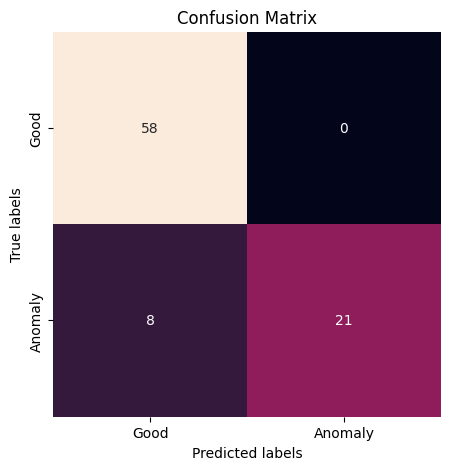

Fold 5/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10: Loss = 0.6875, Accuracy = 0.3471
Epoch 2/10: Loss = 0.5862, Accuracy = 0.5971
Epoch 3/10: Loss = 0.4752, Accuracy = 0.7735
Epoch 4/10: Loss = 0.3914, Accuracy = 0.8618
Epoch 5/10: Loss = 0.2688, Accuracy = 0.8912
Epoch 6/10: Loss = 0.2743, Accuracy = 0.8941
Epoch 7/10: Loss = 0.1601, Accuracy = 0.9500
Epoch 8/10: Loss = 0.1607, Accuracy = 0.9382
Epoch 9/10: Loss = 0.0954, Accuracy = 0.9706
Epoch 10/10: Loss = 0.0514, Accuracy = 0.9882
Accuracy: 0.8605
Balanced Accuracy: 0.7857



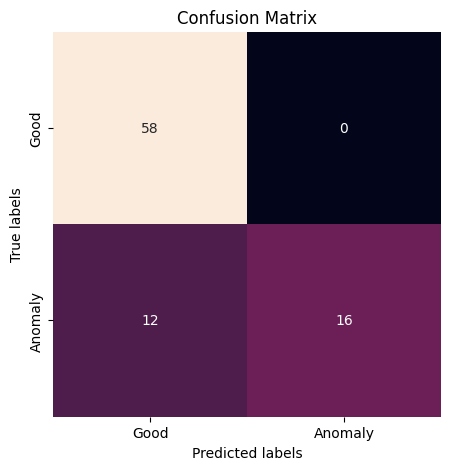

In [17]:
cv_folds = get_cv_train_test_loaders(
    root=data_folder,
    batch_size=batch_size,
    n_folds=n_cv_folds,
)

class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weight)

for i, (train_loader, test_loader) in enumerate(cv_folds):
    print(f"Fold {i+1}/{n_cv_folds}")
    model = CustomVGG()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model = train(train_loader, model, optimizer, criterion, epochs, device)
    evaluate(model, test_loader, device)



# Visualization

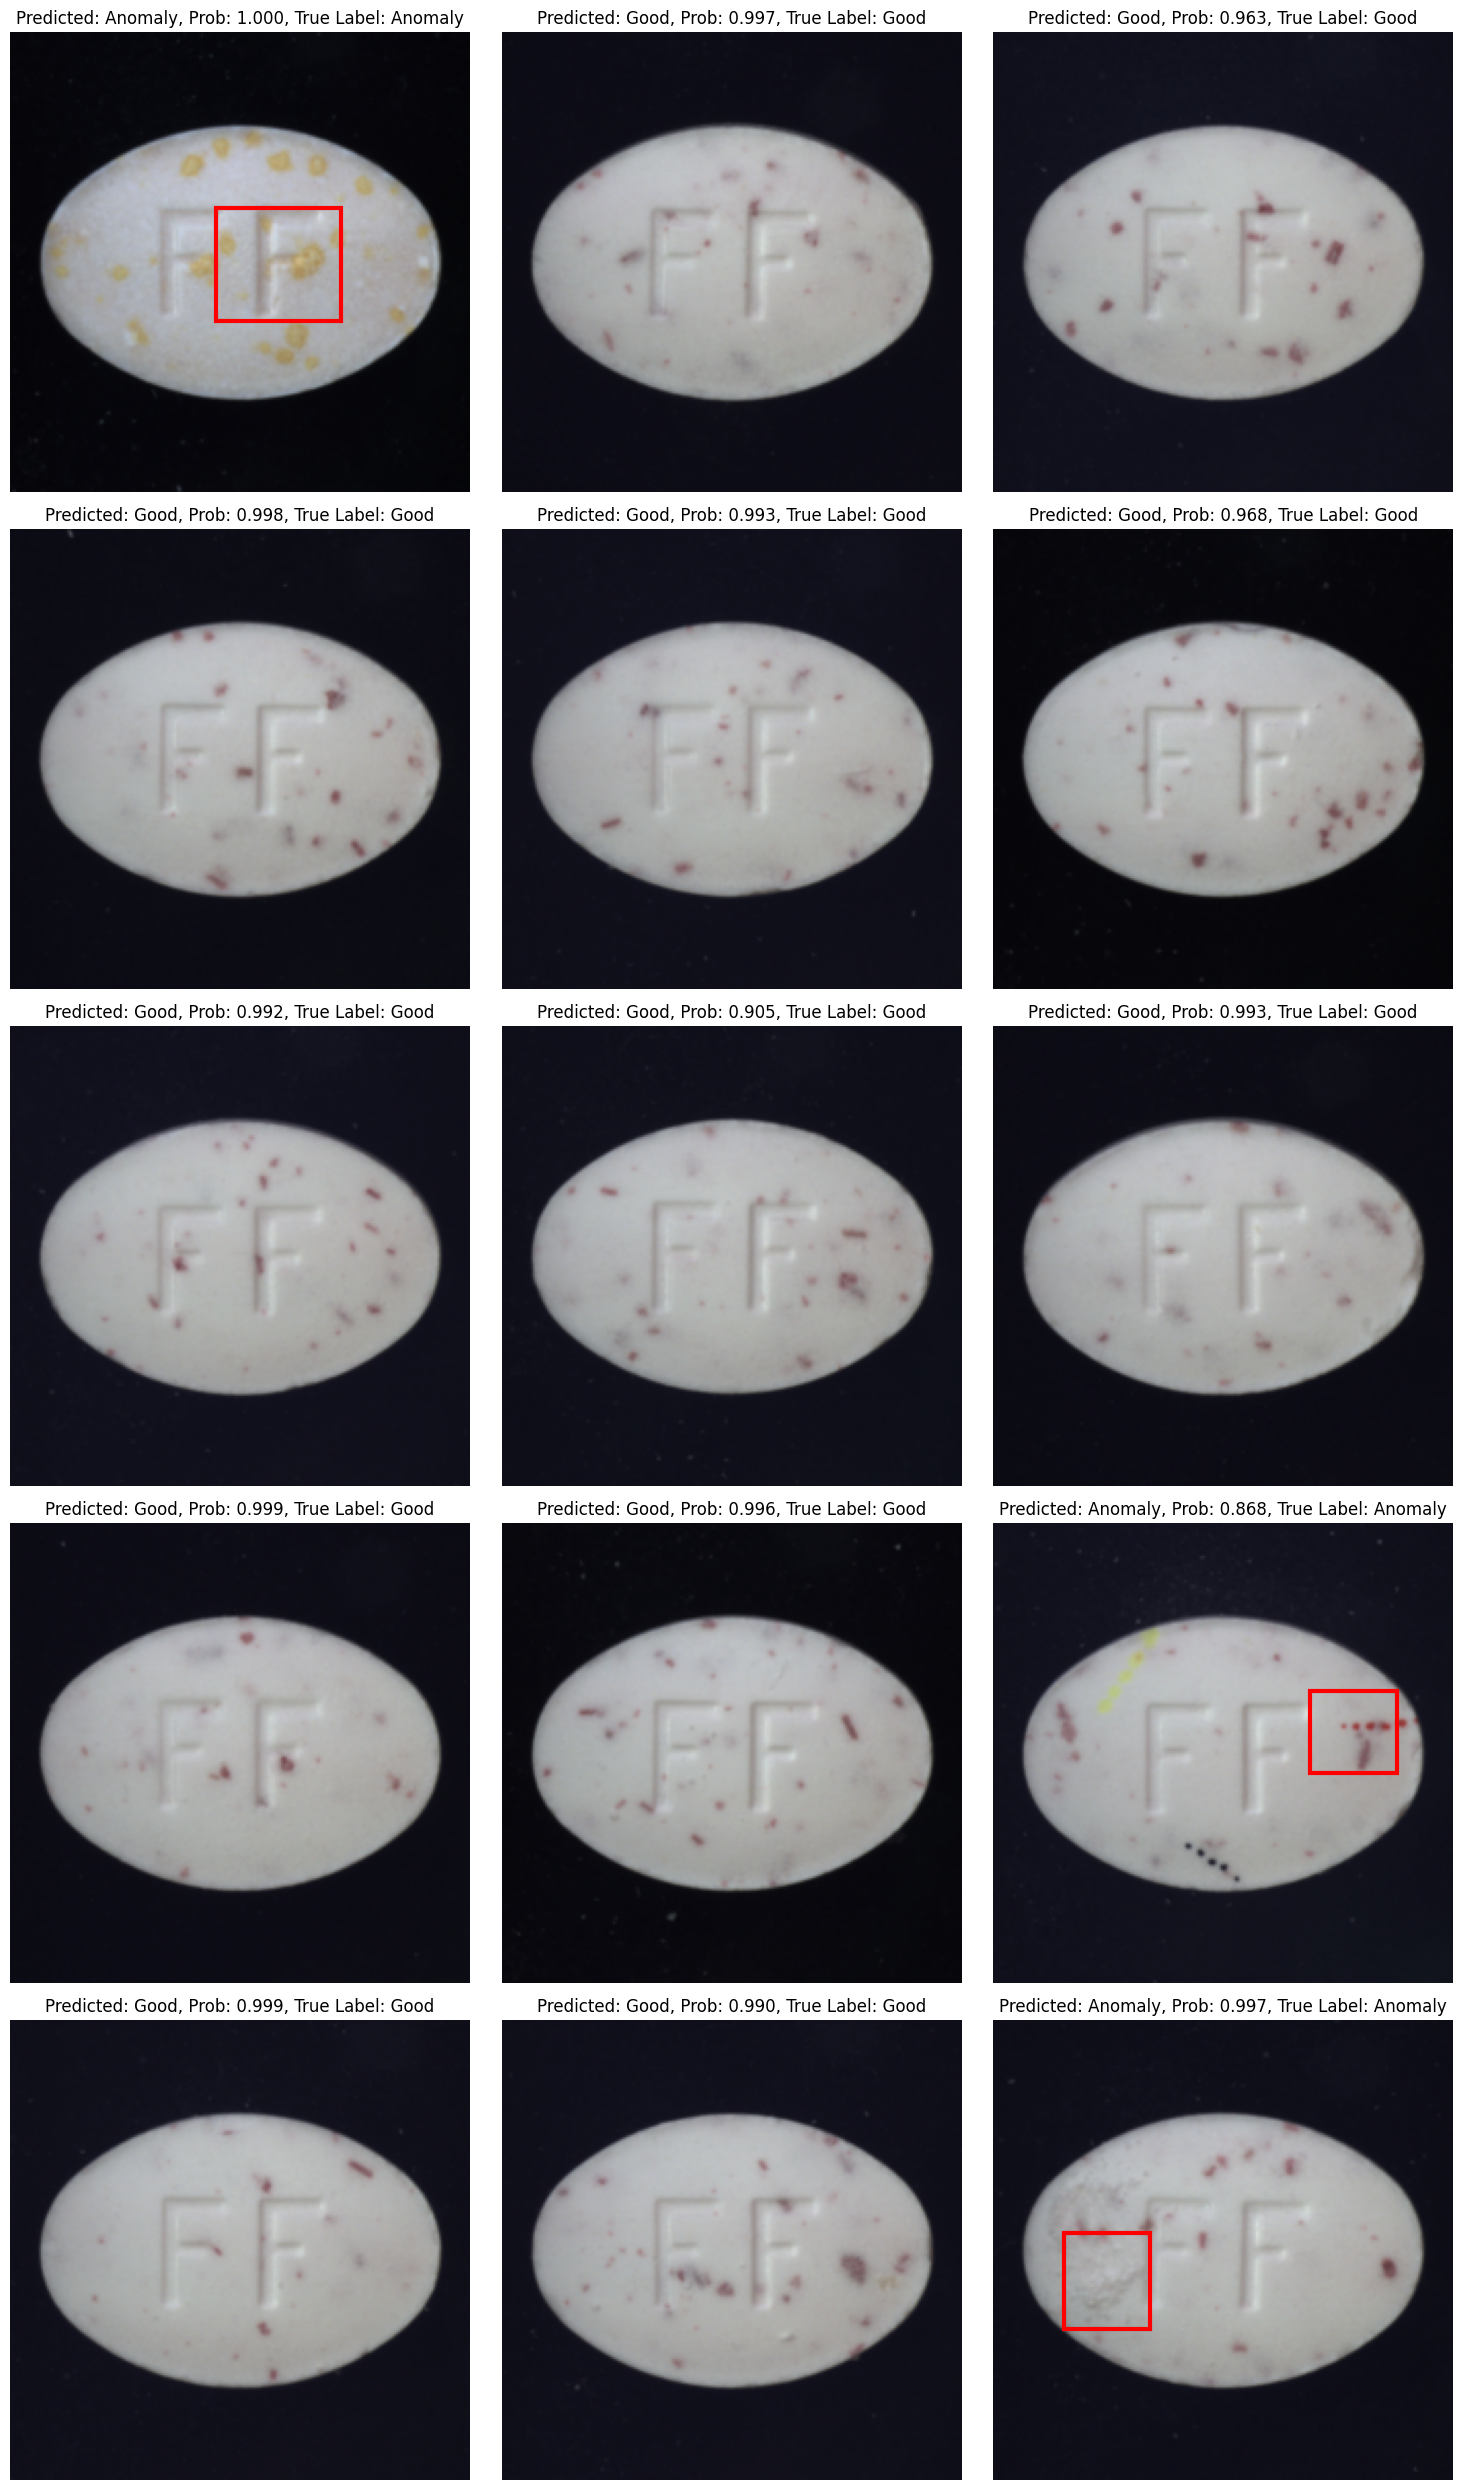

In [20]:
predict_localize(
    model, test_loader, device, thres=heatmap_thres, n_samples=15, show_heatmap=False
)

# References

[1] Zhou, Bolei, Aditya Khosla, Agata Lapedriza, Aude Oliva, and Antonio Torralba: Learning deep features for discriminative localization; in: Proceedings of the IEEE conference on computer vision and pattern recognition, 2016. pdf

[2] Paul Bergmann, Kilian Batzner, Michael Fauser, David Sattlegger, Carsten Steger: The MVTec Anomaly Detection Dataset: A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection; in: International Journal of Computer Vision, January 2021. pdf

[3] Paul Bergmann, Michael Fauser, David Sattlegger, Carsten Steger: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection; in: IEEE Conference on Computer Vision and Pattern Recognition (CVPR), June 2019. pdf

[4] https://towardsdatascience.com/explainable-defect-detection-using-convolutional-neural-networks-case-study-284e57337b59

In [58]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [59]:
%tensorboard --logdir runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-08-21 11:37:06.465126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [57]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile